Aclaracion: para no hacer el archivo largo y repetitivo se fueorn pisando las cosas anteriores a medida que se encontraba algun hiperparametro. El orden en el que se fue buscando cada hiperparametro se encuentra en el informe

In [1]:
! pip3 install bayesian_optimization
! pip3 install xgboost
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
train_values = pd.read_csv('train_values_short1.csv', index_col='building_id')
train_labels = pd.read_csv('train_labels.csv', index_col='building_id')

In [6]:
def target(resultado):
    return resultado['target']

def mostrar(resultados, min=0):
    
    a_borrar = []
    for resultado in resultados:
        if(resultado['target']<min):
            a_borrar.append(resultado)
    resultados_importantes = [a for a in resultados if a not in a_borrar]
    
    resultados_importantes.sort(reverse=True, key=target)
    
    for resultado in resultados_importantes:
        print("target: " , resultado['target'])
        for key,value in resultado['params'].items():
            print("\t\t", key, ':', value)
        print()

In [2]:
def funcion_a_optimizar(n_estimators):
    x = train_values
    le = LabelEncoder()
    y = le.fit_transform(y=train_labels.values.ravel())
    xgb = XGBClassifier( objective = "multi:softmax", use_label_encoder=False, seed=30,
                         max_depth=9,
                         min_child_weight=6,
                         gamma=0.2554138025988315,
                        colsample_bytree = 0.7773754946860542,
                        subsample = 0.9030471581301206,
                         learning_rate =0.1, 
                         n_estimators=round(n_estimators), 
                         )
                       
    return cross_val_score(xgb, x, y, scoring='f1_micro', cv=15).mean()

In [3]:
limites = {"n_estimators":(240,500) }

In [4]:
optimizer = BayesianOptimization(
    f=funcion_a_optimizar,
    random_state=130,
    verbose=5,
    pbounds=limites,
    bounds_transformer=SequentialDomainReductionTransformer(),
)

#load_logs(optimizer, "logs/XGBoost/short1_colsample_y_subsample.json")
logger = JSONLogger(path="./con_feature_engiering_colsample_y_subsample.json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

In [183]:
optimizer.maximize(
    init_points=5,
    n_iter=40,
)

[20:25:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
optimizer.probe({"n_estimators":250 }, lazy=True)

In [ ]:
optimizer.probe({"n_estimators":500 }, lazy=True)

In [7]:
mostrar(optimizer.res)

target:  0.7609794364028688
		 colsample_bytree : 0.7773754946860542
		 subsample : 0.9030471581301206

target:  0.7609755949815245
		 colsample_bytree : 0.7516279046947797
		 subsample : 0.9041745677290469

target:  0.7608835054117528
		 colsample_bytree : 0.793979582481109
		 subsample : 0.9379215375319068

target:  0.7606264015504329
		 colsample_bytree : 0.7469412902446044
		 subsample : 0.9605639199302624

target:  0.760434541187873
		 colsample_bytree : 0.9993754357285763
		 subsample : 0.8854617864361789

target:  0.7603616326628214
		 colsample_bytree : 0.8
		 subsample : 0.8

target:  0.7602963971151808
		 colsample_bytree : 0.870021465386449
		 subsample : 0.9952381867757054

target:  0.7602388388149969
		 colsample_bytree : 0.7417011879574652
		 subsample : 0.9717460034548407

target:  0.7602081371873175
		 colsample_bytree : 0.7773961457821672
		 subsample : 0.5629057093051787

target:  0.7601620931386464
		 colsample_bytree : 0.6899225170721807
		 subsample : 0.56322482572

In [ ]:
param_grid = {'xgbclassifier__n_estimators': [255, 260, 265, 270, 271, 272, 273, 274, 275]}

gs = GridSearchCV(pipe, param_grid, cv=15)
gs.fit(train_values, train_labels)
gs.best_params_

# Feature imoprtance

In [9]:
    xgb_cl = XGBClassifier( objective = "multi:softmax", use_label_encoder=False, seed=30,
                         max_depth=9,
                         min_child_weight=6,
                         gamma=0.2554138025988315,
                        colsample_bytree = 0.7773754946860542,
                        subsample = 0.9030471581301206,
                         learning_rate =0.1, 
                         n_estimators=273,
                        verbosity=0
                         )
                       

In [10]:
x = train_values
le = LabelEncoder()
y = le.fit_transform(y=train_labels.values.ravel())
xgb_cl.fit(x, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7773754946860542,
              gamma=0.2554138025988315, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=9, min_child_weight=6, missing=nan,
              monotone_constraints='()', n_estimators=273, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', random_state=30,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, seed=30,
              subsample=0.9030471581301206, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=0)

AttributeError: module 'matplotlib' has no attribute 'xlabel'

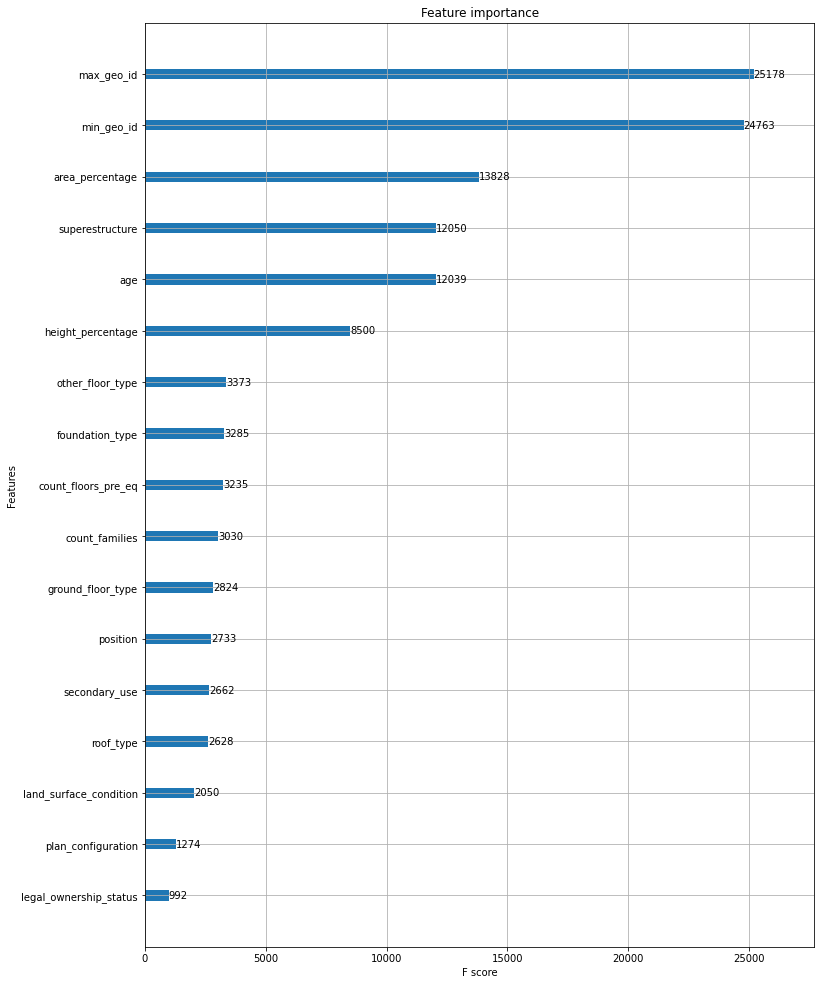

In [11]:
import matplotlib as plt
plt.rcParams['figure.figsize'] =` [12, 17]
xgb.plot_importance(xgb_cl)
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title('Feature imoprtance en xgboost')
plt.savefig('Feature imoprtance XGBoost baseline.png')